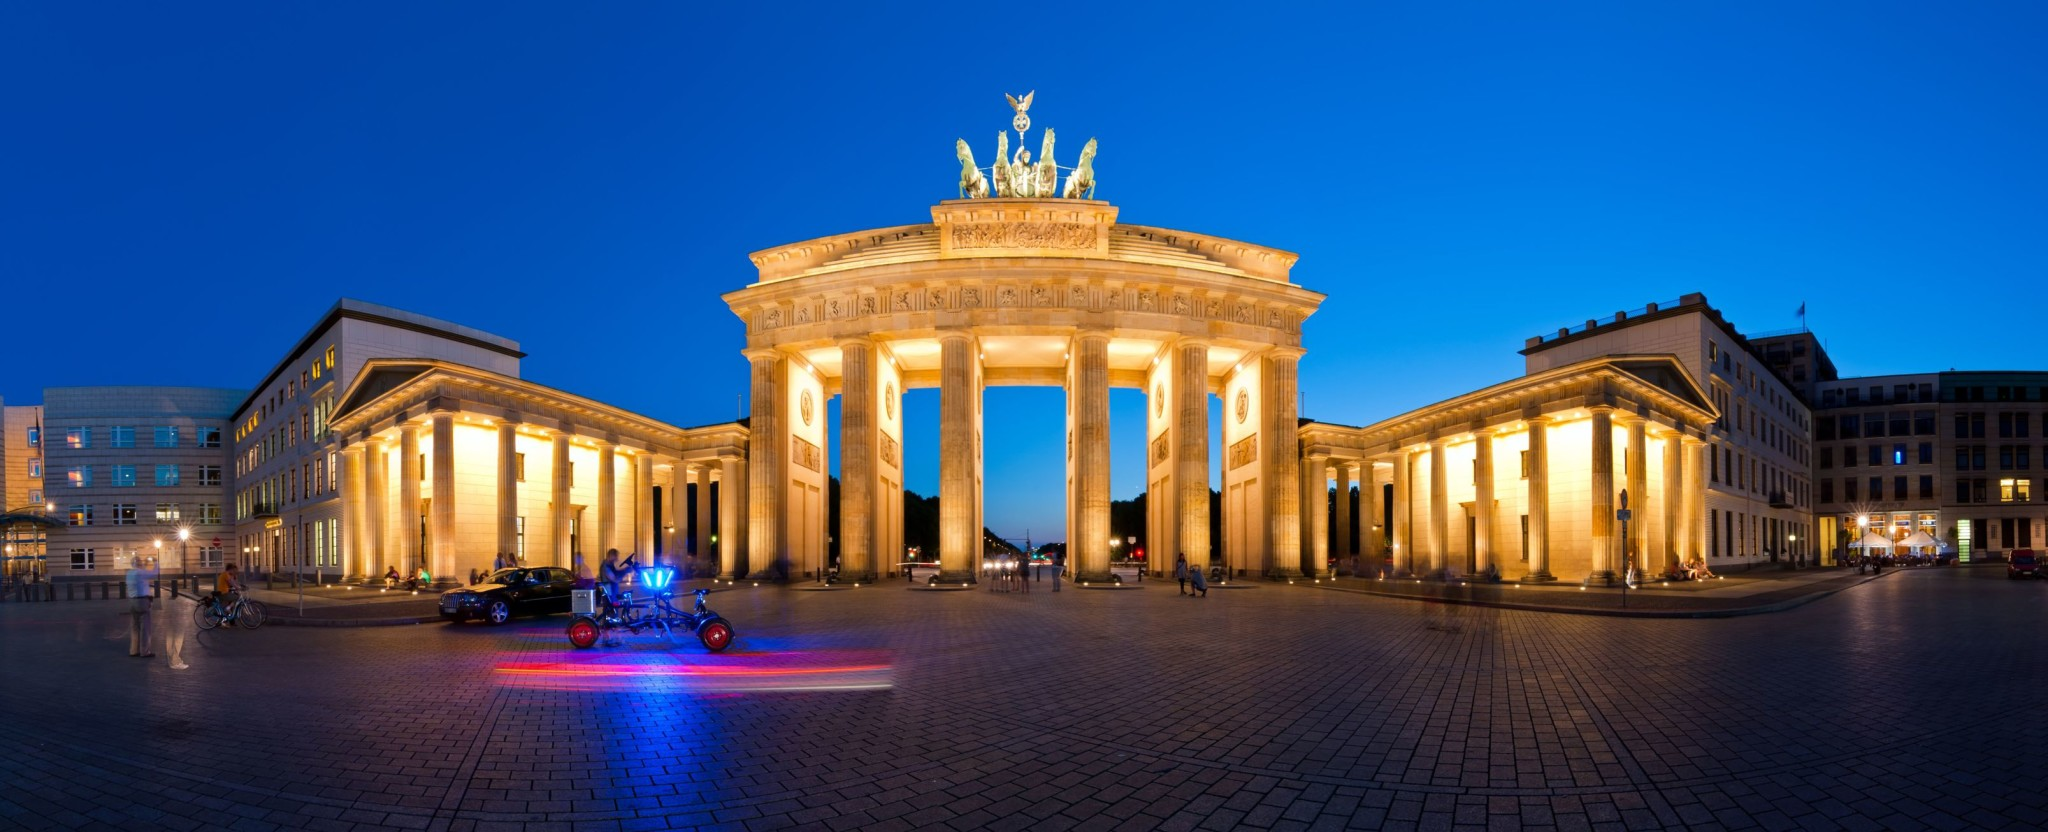
<h1 align=center><font size = 10>Segmenting and Clustering Neighborhoods in Berlin</font></h1>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>
Berlin is the capital city of Germany. It is known to be a cosmopolitan city with a very high number of foreigners from all over the world and very active tourism. Due to the high diversity of the Berline population, the food market is divers as well. In Berlin, there are restaurants from almost all cultures in the world, including Indian restaurant. The Indian food is beloved in Germany, and it is probably in third place after the Italian and Turkish food. Therefore, this work will explore the neighborhoods in Berlin to search for a suitable location to open an __indian restaurant.__

Since there are lots of indian restaurants in Berlin we will try to detect **locations that are not already crowded with indian restaurants** but have high simillirity to the areas with **high number of Indian restaurants** hence an area where the bussiness of indian restaurant is succsessful.

## Data <a name="data"></a>
Based on definition of our problem, factors that will influence our decission are:
* number of existing indian restaurants in the neighborhood.
* the cluster of neighborhood where the indian restaurant is a successful bussiness 

The data will be accuer from deferent resources:
1. The [Wikipidia page Verwaltungsgliederung Berlins](https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins) provides a well ordered list of all the boroughs and there respictive neighboorhoods. This table will be extract using pandas library.
2. The website [Das Örtliche](https://www.dasoertliche.de/Themen/Postleitzahlen/Berlin.html) provides a full list of all Zip codes in Berlin wich will be used later to get a better accurecy for addresses. the list will be exctract using pandas
3. utilizing Geocoder the geographical coordinates of each zip code will be imported to serve as a center of neighborhood 
4. Using[Openstreet maps from Google](https://www.openstreetmap.org/#map=12/52.5080/13.2639&layers=D) a geojson file for each Borough in Berlin as well as the whole city will be imported.
5. Utilizing the [Foursquare API](https://developer.foursquare.com/) all th venius will be imported for exploring the neighborhoods in Berlin and later with cluster analysis searching for the neighboors that are good for opining an indian restaurant 


# 1- Data acquisition
### Utilizing BeautifulSoup, requests & Panda libraries to extract a table from the Wikipedia page: Boroughs and neighborhoods of Berlin
In this part the names of the Boroughs and thier respictive Nieghborhoods will be reatained from the Wekepidia page 

In [67]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder
from sklearn.cluster import KMeans
import folium
import numpy as np 
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from string import digits
import lxml
import re 
import string 
import json
import shapely.geometry
import pyproj
import math
import reverse_geocoder 

In [13]:
# Find all the boroughts and Neighborhoods of Berlin from Wikipidia page "Verwaltungsgliederung Berlins"

web = pd.read_html("https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins")
Berlin=web[2][["Bezirk","Ortsteil"]]
Berlin.head(3)

Bezirk      Ortsteil
0  Mitte         Mitte
1  Mitte        Moabit
2  Mitte  Hansaviertel

In [14]:
#PLZ will used for the Visalisation porpuse and search around them from this website (https://www.dasoertliche.de/Themen/Postleitzahlen/Berlin.html)

html = requests.get('https://www.dasoertliche.de/Themen/Postleitzahlen/Berlin.html').text.replace("<br/>", ', ')
df = pd.read_html(html, attrs={'id': 'tl-plz'})[0]
Location= df[['PLZ','Ortsteil']][:-9]
Location.head(3)

PLZ                      Ortsteil
0  10115                Mitte, Wedding
1  10117  Kreuzberg, Mitte, Tiergarten
2  10119        Mitte, Prenzlauer Berg

## Challenge:
the ZIP codes in Berlin are multiple for one Neighborhood, and one ZIP code could be mutual for tow Nieghborhoods. therefore the borough will be add to the list above. and then and doplicated row will be removed.

In [15]:
## Merge the two data frames together 

# First split the Ortsteil (Nieghborhoods) into seperate rows 
from itertools import chain
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = Location['Ortsteil'].str.split(',').map(len)
# create new dataframe, repeating or chaining as appropriate
data = pd.DataFrame({'PLZ': np.repeat(Location['PLZ'], lens),
                    'Ortsteil': chainer(Location['Ortsteil'])})

# Rest the index and remove any potintial dopplcates 
data = data.drop_duplicates().reset_index(drop=True)
# Insert the columen for Borough
data.insert(1, 'Borough', '')
data.drop([222,229,293], inplace = True) # remove unrelevant data intries 

#merge the Borough and nieghborhoods from two deferent data sources 
for index, row in data.iterrows():
    rep=data.loc[index,'Ortsteil'].strip()
    data.loc[index,'Borough']=Berlin[Berlin['Ortsteil']==rep].iat[0,0]

#Replace the german names of the column by English names 
data =data.rename(columns={"Ortsteil": "Neighborhood"})

# Results
print (data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 465
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PLZ           463 non-null    int64 
 1   Borough       463 non-null    object
 2   Neighborhood  463 non-null    object
dtypes: int64(1), object(2)
memory usage: 34.5+ KB
None


# 2- Geo coordinates acquisition 
### Using the Geocoder import the coordinates for each address
It happes sometimes that the  __geocoder__ retrieve no values (coordinates) and the simple solution is to repeat the request, to avoid  facing this problem the following code will iterate throw the rows of the data frame and keep repeating the coordinates request from the geocoder until a value is received.In this code __the ArcGis__ decoder is used, but it is not the only option, there are many others like  Google Maps, AzureMaps, Bing, etc. Some of them require API keys, while others do not need.
The data will be saved to CSV file as well.

In [ ]:
#initiate an empty vector to store the latitude and longtiude values for following merge with the data frame 
latitude = []
longitude = []
#just for vesualfun
print('Obtaining coordinates: ', end='')

#now loop in the whole table to retrieve all the coordenates for all addresses 
for index, row in data.iterrows():
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}, {}, Berlin, Germany'.format(data.loc[index, 'PLZ'],data.loc[index, 'Borough'],data.loc[index, 'Neighborhood']))  
        lat_lng_coords = g.latlng
        latitude.append(lat_lng_coords[0])
        longitude.append(lat_lng_coords[1])
        print(' .', end='')
print(' done.')
data["Latitude"] = latitude
data["Longitude"] = longitude
#save the data to dat frame
data.to_csv(r'AdressesAndLocation.csv', index = False)
data.head()

Load the Geospatial data 
here the Geocoder and Folium libraries coulnot idebntify the German alphabits so some correction for the names is done here 

In [134]:

with open('AdressesAndLocation.csv', 'r') as myfile:
    data= pd.read_csv(myfile)
data['Borough'] = np.where((data.Borough == 'NeukÃ¶lln'),'Neukölln',data.Borough)
data['Borough'] = np.where((data.Borough == 'Tempelhof-SchÃ¶neberg'),'Tempelhof-Schöneberg',data.Borough)
data['Borough'] = np.where((data.Borough == 'Treptow-KÃ¶penick'),'Treptow-Köpenick',data.Borough)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLZ           463 non-null    int64  
 1   Borough       463 non-null    object 
 2   Neighborhood  463 non-null    object 
 3   Latitude      463 non-null    float64
 4   Longitude     463 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.2+ KB


# 3- Visulized the data
### __GeoJson Berlin:__
The following GeoJson is obtained from merging the json files of the Borough in Berlin after download them separately from Open street maps from Google 

In [17]:
with open('Berlin_allBorough.json', 'r') as myfile:
    GeoJson=myfile.read()

In [86]:
#make a map of Berlin using folium
g = geocoder.arcgis('Berlin')
lat_lng_coords = g.latlng
map_Berlin = folium.Map(width=750,height=500,location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=10)

folium.GeoJson(GeoJson).add_to(map_Berlin)

# add markers to map
for lat, lng, pop1,pop2,pop3 in zip(data['Latitude'], data['Longitude'], data['PLZ'], data['Borough'], data['Neighborhood']):
    label = '{},{},{}'.format(pop1,pop2,pop3)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00FF00',
        fill_opacity=1,
        parse_html=False).add_to(map_Berlin)  
    
map_Berlin

In [ ]:
Berlin_venues = getNearbyVenues(ZIP=data['PLZ'],
                                borough=data['Borough'],
                                neighborhood=data['Neighborhood'],
                                latitudes=data['Latitude'],
                                longitudes=data['Longitude']
                                )

Berlin_venues.to_csv(r'Berlin_venues.csv', index = False)


In [111]:
with open ('Berlin_venues.csv','rb') as myfile:
    Berlin_venues= pd.read_csv(myfile, encoding="utf8")

In [112]:
# Check the size of the resulting dataframe and the number of venius retrieved for each Borough 
print(Berlin_venues.shape)
Berlin_venues.groupby(by='Borough' ,as_index = False).count()

(10748, 9)


Borough   ZIP  Neighborhood  Neighborhood Latitude  \
0   Charlottenburg Wilmersdorf  2137          2137                   2137   
1     Friedrichshain Kreuzberg  1410          1410                   1410   
2                  Lichtenberg   465           465                    465   
3          Marzahn Hellersdorf    74            74                     74   
4                        Mitte  1285          1285                   1285   
5                     Neukolln  1189          1189                   1189   
6                       Pankow   852           852                    852   
7                Reinickendorf   218           218                    218   
8                      Spandau   849           849                    849   
9          Steglitz Zehlendorf   472           472                    472   
10        Tempelhof Schoneberg  1476          1476                   1476   
11            Treptow Kopenick   321           321                    321   

    Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  \
0                     2137   2137            2137             2137   
1                     1410   1410            1410             1410   
2                      465    465             465              465   
3                       74     74              74               74   
4                     1285   1285            1285             1285   
5                     1189   1189            1189             1189   
6                      852    852             852              852   
7                      218    218             218              218   
8                      849    849             849              849   
9                      472    472             472              472   
10                    1476   1476            1476             1476   
11                     321    321             321              321   

    Venue Category  
0             2137  
1             1410  
2              465  
3               74  
4             1285  
5             1189  
6              852  
7              218  
8              849  
9              472  
10            1476  
11             321

We are interested in the information about Indian restaurant therefore a new data frame for all the Indian restaurants in Berlin will be generated. We also include the south Asian restaurants that they might be Indian or very similar.

In [113]:
Indian_Restaurant=Berlin_venues[Berlin_venues['Venue Category'].isin(['Indian Restaurant','Asian Restaurant','South Asian Restaurant','Indi','Hindu','Taj'])]

#check the number of indian restaurants in each Borough
Indian_Restaurant.groupby(by='Borough' ,as_index = False).count()

Borough  ZIP  Neighborhood  Neighborhood Latitude  \
0   Charlottenburg Wilmersdorf   46            46                     46   
1     Friedrichshain Kreuzberg    7             7                      7   
2                  Lichtenberg   10            10                     10   
3                        Mitte   21            21                     21   
4                     Neukolln    2             2                      2   
5                       Pankow   13            13                     13   
6                Reinickendorf    1             1                      1   
7                      Spandau   16            16                     16   
8          Steglitz Zehlendorf   16            16                     16   
9         Tempelhof Schoneberg   68            68                     68   
10            Treptow Kopenick   13            13                     13   

    Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  \
0                       46     46              46               46   
1                        7      7               7                7   
2                       10     10              10               10   
3                       21     21              21               21   
4                        2      2               2                2   
5                       13     13              13               13   
6                        1      1               1                1   
7                       16     16              16               16   
8                       16     16              16               16   
9                       68     68              68               68   
10                      13     13              13               13   

    Venue Category  
0               46  
1                7  
2               10  
3               21  
4                2  
5               13  
6                1  
7               16  
8               16  
9               68  
10              13

make a sub data frame with the borough in berlin and the number of indian restaurants in each of them for making a Choropleth for the dinsity of indian restaurants in each borough 

In [114]:
dfg= Indian_Restaurant[['Borough','Venue Category']]
df_1=dfg.groupby(by='Borough' ,as_index = False).count()
df_2=df_1.rename(columns={"Borough": "Borough", "Venue Category": "Counts"})
df_2.head(3)

Borough  Counts
0  Charlottenburg Wilmersdorf      46
1    Friedrichshain Kreuzberg       7
2                 Lichtenberg      10

Choropleth map to present the borough with the highest density of indian restaurants 

In [115]:
da = world_geo = 'Berlin_allBorough.json'
Berlin_map= folium.Map(width=750,height=500,location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=10)

Berlin_map.choropleth(
    geo_data=da,
    data=df_2,
    columns=['Borough', 'Counts'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Indian Restaurants'
)

# display map
Berlin_map

C:\Users\Nabil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Methodology <a name="methodology"></a>

In this Project we will search for neighborhoods with the lowest number of Indian restaurants in them, because this means that there is still a chance for a new Indian restaurant to be opened. Neighborhoods with no Indian restaurant will not be considered in these analyses for this might refer to the absence of interest from people who live there in the Indian food.

The analysis will be done by finding the neighborhoods with the highest density of an Indian restaurant. Hence the neighborhoods where the Indian restaurant business is successful, and then with the help of cluster analyses We will we will find the neighborhoods that have a low number of Indian restaurants, but are similar to the neighborhoods with the highest density of an Indian restaurant. This similarity will be determined by all the venues in the neighborhoods. 

The existence of a certain types of venues with a high level of density can tell a lot about the market orientation in this area. This is not only depends on the restaurants and there type and density, but also it depends on all other venues because it tells in an indirect way, what is the general mood of people in those neighborhoods.

Therefore, in the cluster analyses all types of venues will be considered to achieve the highest level of accuracy.

## Analysis <a name="analysis"></a>

### Top 10 Nieghboorhood:
We will find the 10 neighborhoods with the highest number of Indian restaurants. The existence of the high number of the Indian restaurants in those Neighborhood indicates the success of such business.

In [116]:
Indian_Restaurant=Berlin_venues[Berlin_venues['Venue Category'].isin(['Indian Restaurant','Asian Restaurant','South Asian Restaurant','Indi','Hindu','Taj'])]
dfg= Indian_Restaurant[['Neighborhood','Venue Category']]
df_1=dfg.groupby(by='Neighborhood' ,as_index = False).count()
df_2=df_1.rename(columns={"Neighborhood": "Neighborhood", "Venue Category": "Counts"})
df_2=df_2.sort_values(by='Counts', ascending=False)
# find Top 10 neighborhoods which have the highest number of indian restaurant
df_top=df_2.head(10)
df_min=df_2.tail(10)

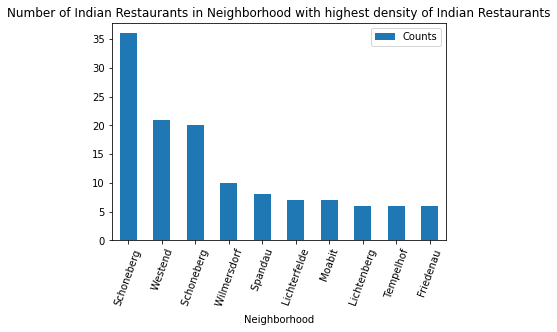

In [117]:
df_top.plot.bar(x="Neighborhood", y="Counts", rot=70, title="Number of Indian Restaurants in Neighborhood with highest density of Indian Restaurants");
plt.show()

Now the cluster analyses to find the potintial nieghborhoods for opening an Indian restaurant 

In [118]:
# one hot encoding
Berlin_onehot = pd.get_dummies(Berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Berlin_onehot['Neighborhood'] = Berlin_venues['Neighborhood'] 

# define a list of column names
cols = Berlin_onehot.columns.tolist()
# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('Neighborhood')))
#then use .reindex() function to reorder
Berlin_onehot = Berlin_onehot.reindex(columns= cols)

#check result
Berlin_onehot.head()


Neighborhood  ATM  Adult Boutique  African Restaurant  American Restaurant  \
0        Mitte    0               0                   0                    0   
1        Mitte    0               0                   0                    0   
2        Mitte    0               0                   0                    0   
3        Mitte    0               0                   0                    0   
4        Mitte    0               0                   0                    0   

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  ...  \
0             0         0       0                       0            0  ...   
1             0         0       0                       0            0  ...   
2             0         0       0                       0            0  ...   
3             0         0       0                       0            0  ...   
4             0         0       0                       0            0  ...   

   Water Park  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0           0           0           0         0          0            0   
1           0           0           0         0          0            0   
2           0           0           0         0          0            0   
3           0           0           0         0          0            0   
4           0           0           0         0          0            0   

   Women's Store  Yemeni Restaurant  Yoga Studio  Zoo Exhibit  
0              0                  0            0            0  
1              0                  0            0            0  
2              0                  0            0            0  
3              0                  0            0            0  
4              0                  0            0            0  

[5 rows x 349 columns]

In [119]:
Berlin_grouped = Berlin_onehot.groupby('Neighborhood').mean().reset_index()
Berlin_grouped.head()

Neighborhood  ATM  Adult Boutique  African Restaurant  \
0   Baumschulenweg  0.0             0.0                 0.0   
1      Blankenburg  0.0             0.0                 0.0   
2        Bohnsdorf  0.0             0.0                 0.0   
3            Britz  0.0             0.0                 0.0   
4             Buch  0.0             0.0                 0.0   

   American Restaurant  Antique Shop  Aquarium  Arcade  \
0                  0.0           0.0       0.0     0.0   
1                  0.0           0.0       0.0     0.0   
2                  0.0           0.0       0.0     0.0   
3                  0.0           0.0       0.0     0.0   
4                  0.0           0.0       0.0     0.0   

   Argentinian Restaurant  Art Gallery  ...  Water Park  Waterfront  \
0                     0.0          0.0  ...         0.0         0.0   
1                     0.0          0.0  ...         0.0         0.0   
2                     0.0          0.0  ...         0.0         0.0   
3                     0.0          0.0  ...         0.0         0.0   
4                     0.0          0.0  ...         0.0         0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0         0.0       0.0        0.0          0.0            0.0   
1         0.0       0.0        0.0          0.0            0.0   
2         0.0       0.0        0.0          0.0            0.0   
3         0.0       0.0        0.0          0.0            0.0   
4         0.0       0.0        0.0          0.0            0.0   

   Yemeni Restaurant  Yoga Studio  Zoo Exhibit  
0                0.0          0.0          0.0  
1                0.0          0.0          0.0  
2                0.0          0.0          0.0  
3                0.0          0.0          0.0  
4                0.0          0.0          0.0  

[5 rows x 349 columns]

In [120]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Berlin_grouped['Neighborhood']

for ind in np.arange(Berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood'].isin(df_top['Neighborhood'])]


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
25     Lichtenberg    Italian Restaurant                 Hotel   
27    Lichterfelde       Auto Dealership              Bus Stop   
35          Moabit                 Hotel           Coffee Shop   
54      Schoneberg     Indian Restaurant            Restaurant   
56         Spandau  Fast Food Restaurant             Drugstore   
61       Tempelhof           Supermarket                  Park   
68         Westend    Italian Restaurant                  Café   
71     Wilmersdorf                 Hotel     French Restaurant   
93       Friedenau                  Café    Italian Restaurant   
130     Schoneberg     Indian Restaurant        Ice Cream Shop   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
25            Supermarket           Coffee Shop                Bakery   
27     Italian Restaurant     Trattoria/Osteria                   Pub   
35                 Bakery                  Café    Italian Restaurant   
54         Ice Cream Shop      Doner Restaurant    Italian Restaurant   
56         Clothing Store    Italian Restaurant                Bakery   
61              Drugstore      Doner Restaurant                  Café   
68                  Hotel          Dessert Shop     German Restaurant   
71     Italian Restaurant     German Restaurant                 Plaza   
93            Supermarket        Clothing Store       Organic Grocery   
130      Doner Restaurant            Restaurant    Italian Restaurant   

     6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
25                Bus Stop   Fast Food Restaurant     Mobile Phone Shop   
27        Doner Restaurant            Gas Station     German Restaurant   
35        Asian Restaurant            Supermarket           Pizza Place   
54           Grocery Store  Vietnamese Restaurant     Trattoria/Osteria   
56       Mobile Phone Shop                   Bank                  Park   
61                  Bakery            Coffee Shop        Breakfast Spot   
68                     Bar               Boutique          Cocktail Bar   
71                    Café            Coffee Shop            Restaurant   
93   Vietnamese Restaurant         Ice Cream Shop                Bakery   
130          Grocery Store  Vietnamese Restaurant                Bakery   

    9th Most Common Venue 10th Most Common Venue  
25                Theater          Shopping Mall  
27                    Bar      Indian Restaurant  
35         Science Museum      Indian Restaurant  
54              Drugstore                   Café  
56                    Pub  Vietnamese Restaurant  
61                   Lake  Vietnamese Restaurant  
68         Breakfast Spot  Vietnamese Restaurant  
71    Japanese Restaurant        Thai Restaurant  
93                 Bistro               Bus Stop  
130     Trattoria/Osteria              Drugstore

###  Cluster Neighborhoods

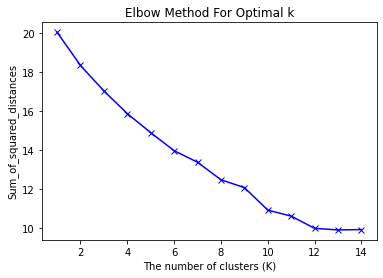

In [122]:
# drop the first coloumn as we dont need the nieghborhood's names for the cluster analysis
Berlin_grouped_clustering = Berlin_grouped.drop('Neighborhood', 1)


#find the ideal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Berlin_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('The number of clusters (K)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [123]:
# set number of clusters
kclusters = 7

Berlin_grouped_clustering = Berlin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 4, 2, 2, 2, 2, 2])

In [124]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Berlin_merged = data

# merge Berlin_grouped with Berlin_data to add latitude/longitude for each neighborhood
Berlin_merged = Berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Berlin_merged.reset_index(drop=True, inplace=True)
Berlin_merged=Berlin_merged.dropna()
#Berlin_merged.reset_index(drop=True, inplace=True)
Berlin_merged.head() # check the last columns!

PLZ                   Borough Neighborhood   Latitude  Longitude  \
0  10115                     Mitte        Mitte  52.531890  13.378140   
1  10115                     Mitte      Wedding  52.532142  13.385789   
2  10117  Friedrichshain-Kreuzberg    Kreuzberg  52.500610  13.418630   
3  10117                     Mitte        Mitte  52.521190  13.424140   
4  10117                     Mitte   Tiergarten  52.516465  13.388040   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             2.0                 Hotel           Coffee Shop   
1             2.0                  Café                 Hotel   
2             2.0                   Bar           Coffee Shop   
3             2.0             Nightclub                 Hotel   
4             2.0                 Hotel           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Plaza             Nightclub                Bakery   
1           Coffee Shop                Bakery           Supermarket   
2                  Café     Korean Restaurant    Turkish Restaurant   
3                 Plaza         Historic Site                  Café   
4           Zoo Exhibit    Italian Restaurant     German Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Supermarket    Italian Restaurant        Breakfast Spot   
1                   Bar             Drugstore              Bus Stop   
2    Chinese Restaurant           Record Shop           Yoga Studio   
3                Bakery            Hookah Bar        Breakfast Spot   
4            Restaurant                  Café                Bakery   

    9th Most Common Venue 10th Most Common Venue  
0                    Café      Trattoria/Osteria  
1            Burger Joint   Gym / Fitness Center  
2            Gourmet Shop  Vietnamese Restaurant  
3  Furniture / Home Store        Organic Grocery  
4          Clothing Store              Hotel Bar

In [128]:
# create map
map_clusters = folium.Map(width=750,height=500,location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=10)

folium.GeoJson(GeoJson).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Berlin_merged['Latitude'], Berlin_merged['Longitude'], Berlin_merged['Neighborhood'], Berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

The map will show the neighborhoods with the highest density of Indian restaurant with red and the potential candidate neighborhoods for opening the Indian restaurant business in green 

In [129]:
Berlin_top= Berlin_merged.loc[Berlin_merged['Neighborhood'].isin(df_top['Neighborhood'])]
Berlin_potintial= Berlin_merged.loc[Berlin_merged['Neighborhood'].isin(df_min['Neighborhood'])]

In [130]:
Berlin_potintial_neighborhoods = Berlin_potintial.loc[Berlin_potintial['Cluster Labels'].isin(Berlin_top['Cluster Labels'])]        

In [131]:
g = geocoder.arcgis('Berlin')
lat_lng_coords = g.latlng
map_Berlin = folium.Map(width=750,height=500,location=[lat_lng_coords[0], lat_lng_coords[1]], zoom_start=10)

folium.GeoJson(GeoJson).add_to(map_Berlin)
# add markers to map
for lat, lng, pop1,pop2,pop3 in zip(Berlin_top['Latitude'],Berlin_top['Longitude'], Berlin_top['PLZ'], Berlin_top['Borough'], Berlin_top['Neighborhood']):
    label = '{},{},{}'.format(pop1,pop2,pop3)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0303',
        fill_opacity=1,
        parse_html=False).add_to(map_Berlin)  
# add markers to map
for lat, lng, pop1,pop2,pop3 in zip(Berlin_potintial_neighborhoods['Latitude'], Berlin_potintial_neighborhoods['Longitude'], Berlin_potintial_neighborhoods['PLZ'], Berlin_potintial_neighborhoods['Borough'], Berlin_potintial_neighborhoods['Neighborhood']):
    label = '{},{},{}'.format(pop1,pop2,pop3)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00FF00',
        fill_opacity=1,
        parse_html=False).add_to(map_Berlin)  
    
map_Berlin

And here is a list of neighborhoods that suit the Indian restaurant business 

In [133]:
Berlin_potintial_neighborhoods

PLZ                     Borough         Neighborhood   Latitude  \
4    10117                       Mitte           Tiergarten  52.516465   
46   10437                       Mitte        Gesundbrunnen  52.545481   
48   10439                       Mitte        Gesundbrunnen  52.556190   
52   10553  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
59   10557                       Mitte           Tiergarten  52.527824   
61   10585  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
62   10587  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
63   10589  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
64   10623  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
65   10623                       Mitte           Tiergarten  52.511645   
66   10625  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
67   10627  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
68   10629  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
69   10707  Charlottenburg-Wilmersdorf       Charlottenburg  52.500194   
72   10709  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
75   10711  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
83   10719  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
94   10785                       Mitte           Tiergarten  52.502838   
95   10787  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
97   10787                       Mitte           Tiergarten  52.504015   
98   10789  Charlottenburg-Wilmersdorf       Charlottenburg  52.499914   
109  10963                       Mitte           Tiergarten  52.505912   
209  12435            Treptow-Köpenick         PlÃ¤nterwald  52.483368   
215  12437            Treptow-Köpenick         PlÃ¤nterwald  52.472904   
314  13347                       Mitte        Gesundbrunnen  52.548683   
318  13353                       Mitte        Gesundbrunnen  52.540524   
321  13355                       Mitte        Gesundbrunnen  52.535474   
324  13357                       Mitte        Gesundbrunnen  52.550911   
325  13359                       Mitte        Gesundbrunnen  52.557570   
338  13409                       Mitte        Gesundbrunnen  52.563217   
341  13435               Reinickendorf  MÃ¤rkisches Viertel  52.597514   
406  13627  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
415  14050  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
422  14055  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
425  14057  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
427  14059  Charlottenburg-Wilmersdorf       Charlottenburg  52.519150   
432  14109                     Spandau               Kladow  52.534870   
439  14165         Steglitz-Zehlendorf           Zehlendorf  52.433520   
447  14193  Charlottenburg-Wilmersdorf        Schmargendorf  52.485237   
452  14195  Charlottenburg-Wilmersdorf        Schmargendorf  52.469517   
456  14197  Charlottenburg-Wilmersdorf        Schmargendorf  52.472327   
461  14199  Charlottenburg-Wilmersdorf        Schmargendorf  52.480879   

     Longitude  Cluster Labels   1st Most Common Venue 2nd Most Common Venue  \
4    13.388040             2.0                   Hotel           Coffee Shop   
46   13.401210             2.0                    Café                   Bar   
48   13.377100             2.0                    Café                   Bar   
52   13.306390             2.0             Supermarket                 Hotel   
59   13.373894             2.0                   Hotel           Coffee Shop   
61   13.306390             2.0             Supermarket                 Hotel   
62   13.306390             2.0             Supermarket                 Hotel   
63   13.306390             2.0             Supermarket                 Hotel   
64   13.306390             2.0             Supermarket                 Hotel   
65   13.333389          

The best Neighborhood to open an Indian Restaurant is mostly the city center with only some exceptions like 14165,Steglitz-Zehlendorf,Zehlendorf and 14109,Spandau,Kladow.
the city center makes a full sense because of the active tourism, and the high density of people in the street. Therefore the city center will be a very suitable place to open the restaurant.
However, opening the restaurant away from the city center might have a lot of risks, but it is also a higher chance to make an extra successful business due to the lake of competition.

## Conclussion <a name="onclussion"></a>

There are some neighborhoods which are highly promising of success Indian restaurant business.However, this analysis must be adjusted with better distributed addresses, maybe an artificial grid will produce better results.